<a href="https://colab.research.google.com/github/grantrzchan/HTX_Armed_Robberies/blob/master/HTX_Armed_Robberies.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
from google.colab import files
uploaded = files.upload()

'''monthly robberies data set'''
import pandas as pd
import io
import math
from sklearn.metrics import mean_squared_error as mse
from math import sqrt
from matplotlib import pyplot as plt

#load data set
data_series = pd.read_csv(io.StringIO(uploaded['robberies.csv'].decode('utf-8')), header=0, index_col=0, parse_dates=True, squeeze=True)

Saving robberies.csv to robberies.csv


In [8]:
#split data set into model development data set and cross validation set, use last year of data as cv
data_end = len(data_series) - 12
data_set, cv_set = data_series[0:data_end], data_series[data_end::]
print(f'Data set: {len(data_set)} months, Validation set: {len(cv_set)} months')

#save training and cv sets to csv format
data_set.to_csv('data_set.csv', header = False)
cv_set.to_csv('cv_set.csv', header = False)

Data set: 106 months, Validation set: 12 months


In [0]:
#create training set and test set
X = data_set.values
X = X.astype('float32')

#start with train set of 50%
train_size = int(0.5*len(X))
train_set, test_set = X[0:train_size], X[train_size::]

In [10]:
#use walk forward validation to create baseline prediction forecast using the persistence model
#create foreacst history
historic_obs = [x for x in train_set]
#create baseline predictions
predictions = []
for i in range(len(test_set)):
    #make prediction at t using observation at t-1
    y_hat = historic_obs[-1]
    predictions.append(y_hat)
    #actual t observation from test set
    observation = test_set[i]
    #update historic observations with actual t observation
    historic_obs.append(observation)
    print(f'Predicted: {y_hat: .3f}, Expected: {observation: .3f}')
#report the performance of the forecast using RMSE
rmse = sqrt(mse(test_set, predictions))
print(f'RMSE: {rmse: .3f}')

Predicted:  98.000, Expected:  125.000
Predicted:  125.000, Expected:  155.000
Predicted:  155.000, Expected:  190.000
Predicted:  190.000, Expected:  236.000
Predicted:  236.000, Expected:  189.000
Predicted:  189.000, Expected:  174.000
Predicted:  174.000, Expected:  178.000
Predicted:  178.000, Expected:  136.000
Predicted:  136.000, Expected:  161.000
Predicted:  161.000, Expected:  171.000
Predicted:  171.000, Expected:  149.000
Predicted:  149.000, Expected:  184.000
Predicted:  184.000, Expected:  155.000
Predicted:  155.000, Expected:  276.000
Predicted:  276.000, Expected:  224.000
Predicted:  224.000, Expected:  213.000
Predicted:  213.000, Expected:  279.000
Predicted:  279.000, Expected:  268.000
Predicted:  268.000, Expected:  287.000
Predicted:  287.000, Expected:  238.000
Predicted:  238.000, Expected:  213.000
Predicted:  213.000, Expected:  257.000
Predicted:  257.000, Expected:  293.000
Predicted:  293.000, Expected:  212.000
Predicted:  212.000, Expected:  246.000
P

In [11]:
# show summary statistics of data_set time series
print(data_set.describe())

count    106.000000
mean     173.103774
std      112.231133
min       29.000000
25%       74.750000
50%      144.500000
75%      271.750000
max      487.000000
Name: Robberies, dtype: float64


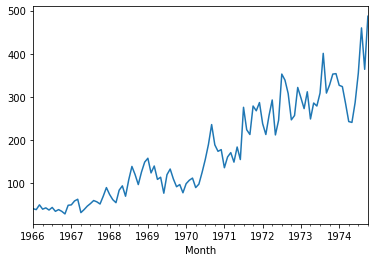

In [12]:
#plot the data
data_set.plot()
plt.show()

### Line plot observations
- There is a trend of increasing robberies
- There is high variability among data points, which corresponds to the wide spread between the quartile ranges observed above
- The variance between data points seem to increase over time, as observed from the widening ampitude of the fluctuations in the data
- The data set is non-stationary

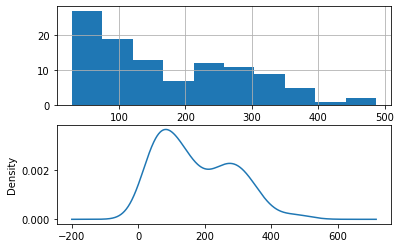

In [13]:
#plot histogram and denisty plot
plt.figure(1)
plt.subplot(211)
data_set.hist()
plt.subplot(212)
data_set.plot(kind='kde')
plt.show()

### Histogram and Density plot observations
- The data distribution is not gaussian
- The data seem to be quadratic or exponential, due to the left shift and the short right tail


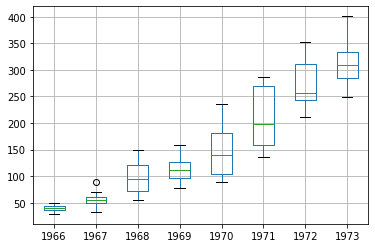

In [14]:
#group data by year for box plot analysis
#1974 only has 10 months and not a full year, so we exclude it
grps = data_set['1966':'1973'].groupby(pd.Grouper(freq='A'))
yrs = pd.DataFrame({name.year: grp.values for name, grp in grps})
yrs.boxplot()
plt.show()

### Box plot observations
- The earlier 2 years seem to have a much smaller variance, with the 1st and 3rd quantile being much closer to the median values.
- The variance changes over time, but does not appear to do so consistently.
- The median values do not exhibit a linear trend.

In [15]:
#Implement an ARIMA model to forecast the number of robberies over time
#first check for stationarity of the data set using the augmented Dickey-Fuller test
from statsmodels.tsa.stattools import adfuller

def check_stationary(data):
    '''function to check data stationarity using adfuller from statsmodel'''
    result = adfuller(data)
    print(f'ADF Statistic: {result[0]: .3f}')
    print(f'p-value: {result[1]: .3f}')
    print(f'Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))


#check if stationary using Dickey-Fuller
check_stationary(data_set.values)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


ADF Statistic:  0.797
p-value:  0.992
Critical Values:
	1%: -3.503
	5%: -2.893
	10%: -2.584


### Dickey-Fuller Test observation:
- The test statistic value is 0.797 , which is larger than the critical value of -2.893. This indicates that we cannot reject the null hypothesis, which claims that the data is non-stationary, with a significance level of less than 5%.

In [16]:
#Employ first order differencing
def differencing(data):
    '''Function executes differencing of order 1 when called'''
    differenced = [(data[i] - data[i-1]) for i in range(1, len(data))]
    return differenced

#executing differencing of order 1
stationary_X = differencing(X)

#check if the data is stationary now
check_stationary(stationary_X)

ADF Statistic: -3.981
p-value:  0.002
Critical Values:
	1%: -3.503
	5%: -2.893
	10%: -2.584


- The test statistic value is -3.981 , which is smaller than the critical value of -2.893. This indicates that we can reject the null hypothesis, which claims that the data is non-stationary, with a significance level of less than 5%.
- Differencing by order of 1 seems to have made the data set stationary.

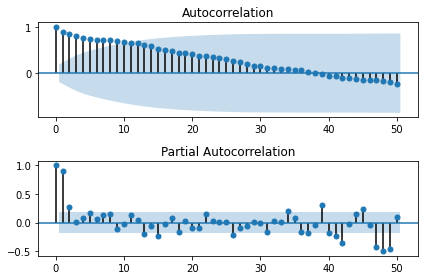

In [17]:
#create ACF and PACF plots to check for autocorrelation
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
plt.figure()
plt.subplot(211)
plot_acf(X, lags=50, ax=plt.gca())
plt.subplot(212)
plot_pacf(X, lags=50, ax=plt.gca())

#fix any plot overlap with tight layout
plt.tight_layout()
plt.show()

### ACF and PACF plot observations

- The ACF plot shows that lags are significant for 10-12 months.
- The PACF plot shows that lags are significant for likely just 2 months.
- The PACF plot suggests that perhaps the autocorrelations at lag 3 and thereafter are due to the propagation of the autocorrelations at lags 1 and 2.
- The plot suggest an ARMA(12,2) that can be used for modelling.
- Since differencing order of the data is 1, an ARIMA(12,1,2) should be a good starting point for modelling the data.

In [18]:
#try an ARIMA model
from statsmodels.tsa.arima_model import ARIMA
arima1212_hist = [x for x in train_set]
arima1212_pred = []
for i in range(len(test_set)):
    # predict
    model = ARIMA(arima1212_hist, order=(0,1,2))
    model_fit = model.fit(disp=0)
    arima1212_y_hat = model_fit.forecast()[0]
    arima1212_pred.append(arima1212_y_hat)
    # observation
    obs = test_set[i]
    arima1212_hist.append(obs)
    print('>Predicted=%.3f, Expected=%.3f' % (arima1212_y_hat, obs))
# report performance
rmse = sqrt(mse(test_set, arima1212_pred))
print(f'RMSE: {rmse: .3f}')

>Predicted=102.710, Expected=125.000
>Predicted=118.868, Expected=155.000
>Predicted=141.099, Expected=190.000
>Predicted=176.593, Expected=236.000
>Predicted=233.418, Expected=189.000
>Predicted=186.905, Expected=174.000
>Predicted=184.846, Expected=178.000
>Predicted=183.763, Expected=136.000
>Predicted=146.180, Expected=161.000
>Predicted=171.279, Expected=171.000
>Predicted=170.196, Expected=149.000
>Predicted=154.425, Expected=184.000
>Predicted=185.708, Expected=155.000
>Predicted=157.284, Expected=276.000
>Predicted=245.280, Expected=224.000
>Predicted=222.242, Expected=213.000
>Predicted=219.698, Expected=279.000
>Predicted=261.506, Expected=268.000
>Predicted=264.287, Expected=287.000
>Predicted=282.759, Expected=238.000
>Predicted=255.843, Expected=213.000
>Predicted=235.189, Expected=257.000
>Predicted=257.622, Expected=293.000
>Predicted=280.345, Expected=212.000
>Predicted=235.564, Expected=246.000
>Predicted=255.342, Expected=353.000
>Predicted=318.613, Expected=339.000
>

In [0]:
#Use Grid Search to find the optimal p,d,q hyperparameters
def evaluate_arima_model(data, arima_order):
    '''Function to evaluate data set X based on ARIMA order with some (p,d,q) and return RMSE'''
    #prepare training data
    data = data.astype('float32')
    train_size = int(len(data) * 0.50)
    train, test = data[0:train_size], data[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    rmse = sqrt(mse(test, predictions))
    return rmse

def evaluate_models(data, p_val, d_val, q_val):
    #convert data set to float to prevent numpy error
    data = data.astype('float32')
    best_rmse, best_config = float('inf'), None
    #loop through all values of p,d,q to try every configuration order for ARIMA
    for p in p_val:
        for d in d_val:
            for q in q_val:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(data, order)
                    if rmse < best_rmse:
                        best_rmse, best_config = rmse, order
                    print('ARIMA%s, RMSE = %.3f' % (order, rmse))
                except:
                    continue
    print('Best ARIMA%s, RMSE = %.3f' % (best_config, best_rmse))

In [20]:
#evaluate data set with all possible hyperparameter configurations
p_val = range(0,13)
d_val = range(0,2)
q_val = range(0,13)

#turn off verbose warning messages
import warnings
warnings.filterwarnings("ignore")
evaluate_models(X, p_val, d_val, q_val)

ARIMA(0, 0, 0), RMSE = 154.962
ARIMA(0, 0, 1), RMSE = 99.360
ARIMA(0, 1, 0), RMSE = 51.827
ARIMA(0, 1, 1), RMSE = 50.417
ARIMA(0, 1, 2), RMSE = 49.821
ARIMA(1, 0, 0), RMSE = 53.243
ARIMA(1, 1, 0), RMSE = 50.582
ARIMA(2, 0, 0), RMSE = 52.032
ARIMA(2, 1, 0), RMSE = 50.761
ARIMA(2, 1, 1), RMSE = 50.407
ARIMA(3, 0, 0), RMSE = 52.234
ARIMA(3, 1, 0), RMSE = 51.901
ARIMA(3, 1, 1), RMSE = 50.295
ARIMA(4, 0, 0), RMSE = 53.335
ARIMA(4, 1, 0), RMSE = 52.420
ARIMA(4, 1, 1), RMSE = 52.295
ARIMA(5, 0, 0), RMSE = 54.044
ARIMA(5, 1, 0), RMSE = 52.653
ARIMA(5, 1, 1), RMSE = 52.883
ARIMA(6, 0, 0), RMSE = 54.142
ARIMA(6, 1, 0), RMSE = 52.437
ARIMA(6, 1, 1), RMSE = 51.488
ARIMA(7, 0, 0), RMSE = 54.121
ARIMA(7, 1, 0), RMSE = 51.104
ARIMA(7, 1, 1), RMSE = 52.340
ARIMA(8, 0, 0), RMSE = 53.099
ARIMA(8, 1, 0), RMSE = 51.759
ARIMA(8, 1, 1), RMSE = 51.942
ARIMA(9, 1, 0), RMSE = 52.491
ARIMA(10, 1, 0), RMSE = 50.661
ARIMA(11, 1, 0), RMSE = 50.960
ARIMA(12, 1, 0), RMSE = 51.174
Best ARIMA(0, 1, 2), RMSE = 49.821


### Grid Search Results
- The best ARIMA model is an ARIMA(0,1,2) with an RMSE of 49.821

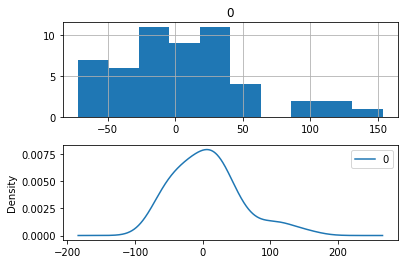

In [26]:
#Check residual errors for other features
#plot residual
residuals = [test_set[i]-arima1212_pred[i] for i in range(len(test_set))]
residuals = pd.DataFrame(residuals)
plt.figure()
plt.subplot(211)
residuals.hist(ax=plt.gca())
plt.subplot(212)
residuals.plot(kind='kde', ax=plt.gca())
plt.show()

### Histogram and density plot observations
- Both histogram and density plots show a distribution that is much closer to Gaussian, however, the longer right tail suggests that some other relationship has not been captured.

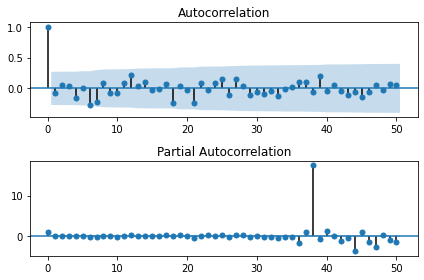

In [36]:
#check ACF and PACF
plt.figure()
plt.subplot(211)
plot_acf(residuals, lags=50, ax=plt.gca())
plt.subplot(212)
plot_pacf(residuals, lags=50, ax=plt.gca())
plt.tight_layout()
plt.show()

### ACF and PACF observations
- Any correlation and partial correlation seems to have been captured.
- There is an anomaly at t-38 in the PACF plot.

In [39]:
#use Box-Cox transform to further evaluate starting data set for any potential relationships
from scipy.stats import boxcox
from statsmodels.graphics.gofplots import qqplot
transformed, lamd = boxcox(X)
print(f'Lambda: {lamd: .3f}')

Lambda:  0.260


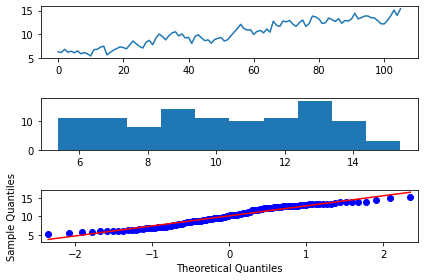

In [46]:
#plot transformed data, histogram and q-q plots
plt.figure()
#plot transformed data
plt.subplot(311)
plt.plot(transformed)
#plot histogram
plt.subplot(312)
plt.hist(transformed)
#plot q-q plot
plt.subplot(313)
qqplot(transformed, line='r', ax=plt.gca())
plt.tight_layout()
plt.show()

### Data transform results
- Transforming the data has reduced the high variability of the data in the later years.
- The transformed data has a more uniform and well-behaved distribution
- The transformed data is still not perfectly Gaussian.